In [1]:
import os
import numpy as np

from ipywidgets import interact_manual, Layout
import ipywidgets as widgets
from glob import glob
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from src.datasets import load_dataset_JIF, SatelliteDataset, DictDataset, make_transforms_JIF
from src.datasources import S2_ALL_12BANDS
from src.plot import showtensor
from multiprocessing import Manager
from src.datasources import *
transforms = make_transforms_JIF(lr_bands_to_use='true_color', radiometry_depth=12)
multiprocessing_manager = Manager()

dataset_root = '/scratch/partenza.g/'
hr_dataset_folder = 'hr_dataset/12bit/'
lr_dataset_folder = 'lr_dataset/'

In [2]:
lr = SatelliteDataset(
    root=os.path.join(dataset_root, lr_dataset_folder, "*", "L2A", ""),
    file_postfix="-L2A_data.tiff",
    transform=transforms["lr"],
    number_of_revisits=8,
    bands_to_read=S2_ALL_12BANDS["true_color"],
    multiprocessing_manager=multiprocessing_manager
)

lrc = SatelliteDataset(
    root=os.path.join(dataset_root, lr_dataset_folder, "*", "L2A", ""),
    file_postfix="-CLM.tiff",
    transform=transforms["lrc"],
    number_of_revisits=8,
    multiprocessing_manager=multiprocessing_manager
)

hr_panchromatic = SatelliteDataset(
    root=os.path.join(dataset_root, hr_dataset_folder, "*"),
    file_postfix="_pan.tiff",
    transform=transforms["hr_pan"],
    number_of_revisits=1,
    multiprocessing_manager=multiprocessing_manager
)

hr_rgb = SatelliteDataset(
    root=os.path.join(dataset_root, hr_dataset_folder, "*"),
    file_postfix="_rgbn.tiff",
    transform=transforms["hr"],
    bands_to_read=SPOT_RGB_BANDS,
    number_of_revisits=1,
    multiprocessing_manager=multiprocessing_manager
)

hr_pansharpened = SatelliteDataset(
    root=os.path.join(dataset_root, hr_dataset_folder, "*"),
    file_postfix="_ps.tiff",
    transform=transforms["hr"],
    bands_to_read=SPOT_RGB_BANDS,
    number_of_revisits=1,
    multiprocessing_manager=multiprocessing_manager
)

dataset = DictDataset(
    **{
        "lr": lr,
        "lrc": lrc,
        "hr": hr_rgb,
        "hr_pan": hr_panchromatic,
        "hr_pansharpened": hr_pansharpened,
    }
)

print(f"Loaded dataset with {len(dataset)} images.")

Loaded dataset with 3928 images.


In [3]:
from torchvision.transforms import Compose, Resize, InterpolationMode, Normalize, Lambda

def make_transforms_JIF(
    input_size=(160, 160),
    output_size=(1054, 1054),
    interpolation=InterpolationMode.BICUBIC,
    normalize_lr=True,
    scene_classification_to_color=False,
    radiometry_depth=12,
    lr_bands_to_use="all",
    **kws,
):
    """ Make the transforms for the JIF dataset.
    The transforms normalize and resize the images to the appropriate sizes.

    Parameters
    ----------
    input_size : tuple
        The size of the (LR) input image, by default (160, 160).
    output_size : tuple
        The size of the (HR) output image, by default (1054, 1054).
    interpolation : torchvision.transforms.InterpolationMode, optional
        InterpolationMode to use when resizing the images, by default InterpolationMode.BILINEAR.
    normalize_lr : bool, optional
        A flag to normalize the LR images, by default True.
    scene_classification_to_color : bool, optional
        Converts the scene classification layer values to colors, by default False.
        See: https://www.sentinel-hub.com/faq/how-get-s2a-scene-classification-sentinel-2/
    **kws : dict
        The keyword arguments dictionary from which the input_size and output_size are fetched.

    Returns
    -------
    dict of {str : Callable}
        The LR, HR and scene classification transforms.
    """

    if radiometry_depth == 8:
        maximum_expected_hr_value = SPOT_MAX_EXPECTED_VALUE_8_BIT
    else:
        maximum_expected_hr_value = SPOT_MAX_EXPECTED_VALUE_12_BIT

    transforms = {}
    if lr_bands_to_use == "true_color":
        lr_bands_to_use = np.array(S2_ALL_12BANDS["true_color"]) - 1
    else:
        lr_bands_to_use = np.array(S2_ALL_BANDS) - 1

    if normalize_lr:
        normalize = Normalize(
            mean=JIF_S2_MEAN[lr_bands_to_use], std=JIF_S2_STD[lr_bands_to_use]
        )
    else:
        normalize = Compose([])

    transforms["lr"] = Compose(
        [
            Lambda(lambda lr_revisit: torch.as_tensor(lr_revisit)),
            normalize,
            Resize(size=input_size, interpolation=interpolation, antialias=True),
        ]
    )

    transforms["lrc"] = Compose(
        [
            Lambda(
                lambda lr_scene_classification: torch.as_tensor(lr_scene_classification)
            ),
            # Categorical
            Resize(size=input_size, interpolation=InterpolationMode.NEAREST),
            # Categorical to RGB; NOTE: interferes with FilterData
            SceneClassificationToColorTransform
            if scene_classification_to_color
            else Compose([]),
        ]
    )

    transforms["hr"] = Compose(
        [
            Lambda(
                lambda hr_revisit: torch.as_tensor(hr_revisit.astype(np.int32))
                / maximum_expected_hr_value
            ),
            Resize(size=output_size, interpolation=interpolation, antialias=True),
            Lambda(lambda high_res_revisit: high_res_revisit.clamp(min=0, max=1)),
        ]
    )

    transforms["hr_pan"] = Compose(
        [
            Lambda(
                lambda hr_panchromatic: torch.as_tensor(
                    hr_panchromatic.astype(np.int32)
                )
                / maximum_expected_hr_value
            ),  # sensor-dependent
            Resize(size=output_size, interpolation=interpolation, antialias=True),
            Lambda(
                lambda high_res_panchromatic: high_res_panchromatic.clamp(min=0, max=1)
            ),
        ]
    )
    # transforms["metadata"] = Compose([])
    return transforms

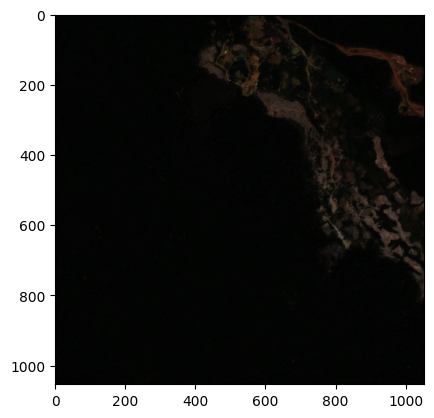

In [175]:
res = make_transforms_JIF()
example = dataset[3]['hr_pansharpened'][0]
example = res['hr'].transforms[1](example)
plt.imshow(example.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


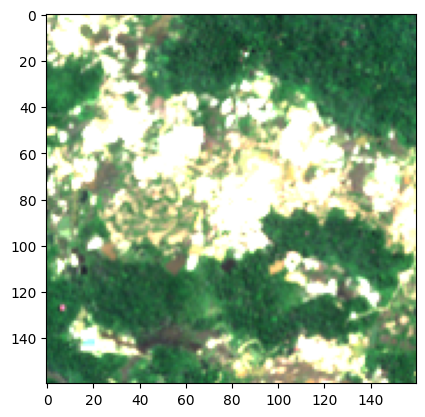

In [177]:
example = dataset[10]['lr'][0]
plt.imshow(example.permute(1,2,0))

In [8]:
res = make_transforms_JIF()
x = dataset[0]['hr'][0]
x = res['hr'].transforms[1](x)
x.shape

torch.Size([3, 1054, 1054])

In [9]:
x -= x.min(1, keepdim=True)[0]
x /= x.max(1, keepdim=True)[0]

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
x

In [ ]:
plt.imshow(x)